# Autodiff and Gradient Descent in Pure Python

After Jackson's lecture on backpropagation, let's try to implement a minimal version of autodiff and gradient descent in pure python.
The functionality and speed of the code will not be enough for real deep learning, but it's a good way to help us understand these important ingredients.

## Autodiff with Dual Numbers

There are many ways to implement autodiff (and backpropagation).
For the purpose for this quick demo, we will use the dual number formulation.

The idea is, for each variable $x$ in a function $f$, we always keep a copy of its derivative with us.
The variable $x$ and its derivative $x'$ together form a "dual number" $(x,x')$ that follows some algebraic rules:
* Linearity: $(a,a') + (b,b') = (a+b, a'+b')$;
* Product Rule: $(a,a') (b,b') = (ab, a'b + ab')$.
Using these simple algebraic properties, we are ready to create our own autodiff!

The idea is pretty simple.
Consider a algebraic function $f(x)$ and evaluating it at $x_0$, instead of passing `x0` to it, we pass a dual number `(x0,1)` to `f`.
The above algebric rule will automatically propagate both the variable and its derivative along the function, making the python function returns both the value $f(x)$ and derivative $f'(x)$.

In order to handle, e.g., multiplication, with normal python numbers, we first create helper functions that select the value and derivative from a dual number.

In [1]:
def V(x):
    """Select the value from a dual number.
    
    Work for both python built-in numbers (often used in function) and dual numbers.
    """
    if isinstance(x, Dual):
        return x[0]
    else:
        return x

def D(x):
    """Select the derivative from a dual number.
    
    Work for both python built-in numbers (often used in function) and dual numbers.
    """
    if isinstance(x, Dual):
        return x[1]
    else:
        return 0

We then define the `Dual` class and override algebraic operators.
To make unpacking the value and derivative easy, we implement `Dual` as a `tuple`.

In [2]:
class Dual(tuple):
    """Dual number for implementing autodiff in pure python"""

    def __new__(self, v, d=1): # tuple is immutable so we cannot use __init__()
        return tuple.__new__(Dual, (v, d))

    def __add__(self, r):
        return Dual(
            V(self) + V(r),
            D(self) + D(r),
        )
    def __radd__(self, l):
        return self + l
        
    def __mul__(self, r):
        return Dual(
            V(self) * V(r), 
            V(self) * D(r) + D(self) * V(r),
        )
    def __rmul__(self, l):
        return self * l

    def __pow__(self, r):
        if V(r) == 0:
            return Dual(1, 0)
        else:
            return Dual(
                V(self)**V(r),
                V(r) * V(self)**(V(r)-1),
            )

That's it!
We've implemented (a limited version of) autodiff in pure python!
Let's test it out.
We will plot both a function $f(x)$ and its derivative $f'(x)$ as tangent lines.

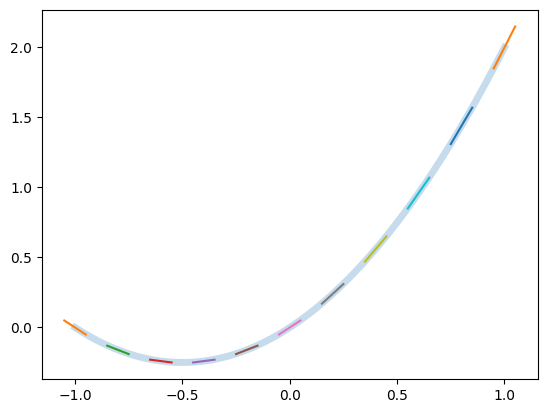

In [3]:
import numpy as np
from matplotlib import pyplot as plt

def f(x):
    return x + x*x

X     = np.linspace(-1,1,num=101)
Y, dY = f(Dual(X))

plt.plot(X, Y, lw=5, alpha=0.25)
for (x, y, dy) in list(zip(X, Y, dY))[::10]:
    plt.plot(
        [x-0.05,    x+0.05],
        [y-0.05*dy, y+0.05*dy],
    )

## Exercise/hack 1

**1a)** In the above cell, redefine function $f$ as
\begin{align}
    f(x) = 2x + x^2
\end{align}
and try our autodiff.

Ooops... it is not going to work.

This is because when python sees `2 * x`, it uses the `__mul__()` function in class/type `int`, which doesn't understand Dual number.

In order to make `[int] * [Dual]` works, implement the `__rmul__()` method in class `Dual` and check if autodiff work with this new function.

**1b)** By the same token, implement `__radd__()` so our autodiff works for
\begin{align}
    f(x) = 3 + 2x + x^2.
\end{align}

**1c)** Take a look at the list of [magic methods](https://docs.python.org/3/reference/datamodel.html#emulating-numeric-types), implement some of them so our autodiff works for more algebraic functions. 

## Chain rule

The dual number formulation makes implementing autodiff in python super simple.
However, our implementation so far only works for basic algebraic equations.
To generalize our autodiff to more complicated equations, we need to use the chain rule.
The idea is very similar, we define our own function where the "value" slot we return the function itself, but the "derivative" slot we return the derivative of the function using chain rule.

In [4]:
def sin(x):
    return Dual(
        np.sin(V(x)),
        np.cos(V(x)) * D(x), # chain rule [f(g)]' = f'(g) g'
    )

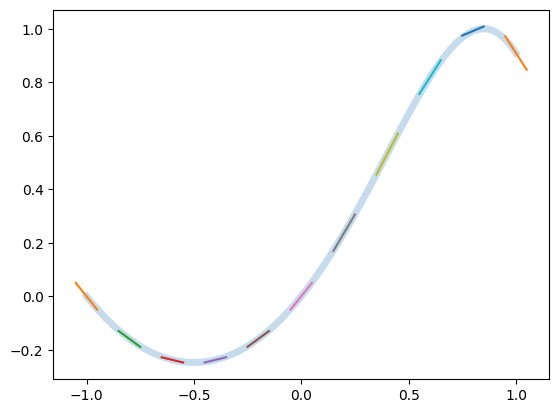

In [5]:
def f(x):
    return sin(x + x*x)

Y, dY = f(Dual(X))

plt.plot(X, Y, lw=5, alpha=0.25)
for (x, y, dy) in list(zip(X, Y, dY))[::10]:
    plt.plot(
        [x-0.05,    x+0.05],
        [y-0.05*dy, y+0.05*dy],
    )

## Exercise/hack 2

**2a)** In the above cells, define your own autodiff-able `cos` function, redefine function $f$ as
\begin{align}
    f(x) = \cos(2x + x^2),
\end{align}
and try our autodiff.

**2b)** By the same token, implement `__pow__()` in class `Dual` so our autodiff works when we write `x*x` as `x**2`.

## Gradient Descent

We are now ready to implement our own very simple version of gradient descent.
Using the same function $f(x) = \sin(x + x^2)$, we are interesting in finding its minimum at $x = 0.5$.

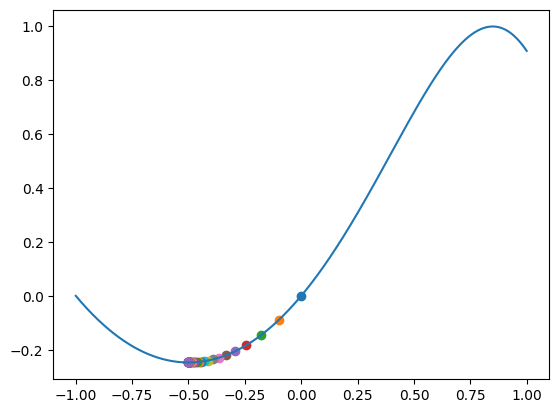

In [6]:
X = np.linspace(-1,1,num=10001)
plt.plot(X, f(X)[0])

x    = 0.0 # initial value
rate = 0.1 # learning rate

y, dy = f(Dual(x))
plt.scatter([x], [y])

while abs(dy) > 1e-6:
    x = x - rate * dy
    y, dy = f(Dual(x))
    plt.scatter([x], [y])

#plt.xlim(-0.51, -0.49)
#plt.ylim(-0.247425,  -0.2473)

## Exercise/hack 3

**3a)** In the above cell, print different variables to help you understand how gradient descent works.

**3b)** In the above cell, try adjust the learning rate and see how it improves or breaks gradient descent.

**3c)** Are there other strategies?  How about we adjust the learning rate according to the gradient?

## Exercise/hack 4

Use our autodiff tools to compute partial derivative.

In [7]:
def f(x, y):
    return x * x + 2 * x * y + 3 * y * y

display(f(Dual(1), 1)[1]) # 2x + 2y -> 4
display(f(1, Dual(1))[1]) # 2y + 6y -> 8

4

8

In [8]:
def f(x):
    return x[0] * x[0] + 2 * x[0] * x[1] + 3 * x[1] * x[1]

display(f((Dual(1), 1))[1]) # 2x + 2y -> 4
display(f((1, Dual(1)))[1]) # 2y + 6y -> 8

4

8

## Exercise/hack 5

Apply gradient descent to find the minimum of a multi-variable function.

0 0 0
-0.1 -0.1 -0.14
-0.16 -0.12 -0.1728
-0.20400000000000001 -0.11599999999999999 -0.190688
-0.24000000000000002 -0.10559999999999999 -0.20385792000000003
-0.27088 -0.09423999999999999 -0.2140450304
-0.297856 -0.08352 -0.221977165824
-0.3215808 -0.0738368 -0.22815877554176
-0.34249728 -0.06521856 -0.23297671267614722
-0.360954112 -0.05758796799999999 -0.23673185915253556
-0.377245696 -0.05084436480000001 -0.23965866178042136
-0.39162768384 -0.04488860672000001 -0.241939844609212
-0.40432442572800004 -0.03962990591999999 -0.24371782417252152
-0.41553355939840003 -0.03498707722239999 -0.24510360145445673
-0.42542943207424005 -0.030888119009279985 -0.24618369186479622
-0.43416592185753605 -0.02726936118886398 -0.24702552648699125
-0.44187886524825604 -0.024074560104038384 -0.24768166186635232
-0.44868818017779716 -0.021254050991964153 -0.2481930611658099
-0.4546997339438449 -0.018763984361226234 -0.24859165153559068
-0.46000699028283065 -0.01656564695572151 -0.2489023173559203
-0.464692

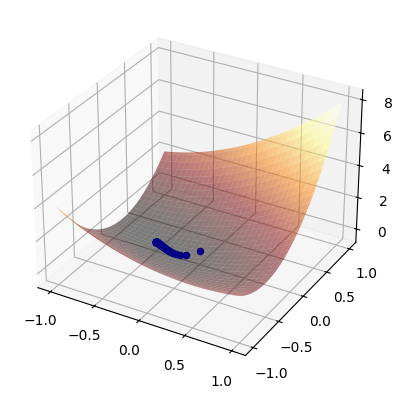

In [9]:
def f(x, y):
    return x * x + 2 * x * y + 3 * y * y + x + y

X = np.linspace(-1, 1, num=101)
Y = np.linspace(-1, 1, num=101)
X, Y = np.meshgrid(X, Y)
Z = f(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, Z, cmap='afmhot', alpha=0.5)

x, y = 0, 0 # initial value
rate = 0.1  # learning rate

z, dzdx = f(Dual(x), y)
z, dzdy = f(x, Dual(y))
ax.scatter([x], [y], [z], color='b')
print(x, y, z)

while (dzdx*dzdx + dzdy*dzdy)**0.5 > 1e-6:
    x = x - rate * dzdx
    y = y - rate * dzdy
    z, dzdx = f(Dual(x), y)
    z, dzdy = f(x, Dual(y))
    ax.scatter([x], [y], [z], color='b')
    print(x, y, z)

## Second derivative

Once `__radd__()`, `__rmul__()`, etc are implemented, our autodiff also works for second derivatives.

In [10]:
def f(x):
    return 3 * x * x

def df(x):
    return f(Dual(x,1))[1]

def ddf(x):
    return df(Dual(x,1))[1]

print(f(5))
print(df(5))
print(ddf(5))

75
30
6
